In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import csv


In [2]:
#suppose m receptors
#suppose x bacteria
#suppose y phages
#each bacteria may have n phages bound to it
#each bacteria may have n' phages permanently bound to it
#n+n'<=m

#initialize an array containing all the available bacteria and their receptors
def initiate_bacteria(num_bacteria, receptors):
    #different rows represent different bacteria
    #different columns represent receptor freedom
    #3 states of receptor freedom
    #0 == free
    #1 == nonperm bounded
    #2 == perm bounded
    #The sum of these must be less than or equal to m
    #m must be less than or equal to M
    M = receptors
    #each bacteria can have a stochastic number of m receptors less than or equal to M
    #A healthy, non phage challenged bacteria may have up to 150+ receptors
    m_rows = np.random.randint(low = 50, high = 150, size = (num_bacteria,1)) #generates random number of receptors
    free_m = m_rows
    non_perm_m = np.zeros((num_bacteria,1))
    perm_m = np.zeros((num_bacteria,1))
    
    pop = np.hstack((free_m,non_perm_m))
    pop = np.hstack((pop,perm_m))
    pop = np.hstack((pop,m_rows))
    #the last column of pop will tell you the number of receptors for each bacteria
    #when we update m, it must not be lower than the sum of the first 3 columns of pop for each bacteria
    return pop;


def update_data(pop,max_receptors):
    #rows that says how many bacteria have nonperm
    #columns that say how many bacteria have perm
    #this will be MxM sized matrix
    #flatten this matrix into array? 
    # -- > row i and col j --> number bacteria with 
    data = np.zeros((max_receptors,max_receptors))
    receptors = pop[:,-1] #the last column of pop is number of receptors
    #0 == free receptors
    #1 == nonperm receptors
    #2 == perm receptors
    #3 == number of receptors for that bacteria
    species, count = np.unique(pop[:,1:3], axis = 0, return_counts = True)
    #print('-------------species----------------')
    #print(species)
    #print('----------count-----------')
    #print(count)
    for s in enumerate(species):
        spc = s[1]
        i = int(spc[0]) #nonperm bounded
        j = int(spc[1]) #perm bounded
        data[i,j] = count[s[0]]
    #at some point m will be dynamic
    #m = pop[:,-1]
    
    return data;



We can define every reaction as $h_v$ and corresponding reaction kinetic rate as $c_v$ for $v \in [1,M]$ for $M$ reactions.  For the sake of notation, let us define every possible reaction $a_v = h_v \cdot k_v$.  

Probability $P_0$ that nothing happens within the infinitesimal timeframe
$$P_0(\tau) = exp[-\sum_i{a_v\cdot\tau}] $$

It should be understood that $exp[-a_v\cdot \tau]$ is the probability reaction $R_v$ will not occur in time interval $(t,t+\tau)$ only in the absence of all other reaction channels that also involve overlapping reactants of $R_v$.

Hence $P(\tau,u) = h_u k_u exp[-\sum_{v=1}^M{h_vk_v\tau}] = h_uk_uP_o(\tau)$

Thus $\int_0^\infty d\tau\cdot \sum_{u=1}^M{P(\tau,u)} 
= \sum_{u=1}^Mh_uk_u \int_0^\infty d\tau \cdot P_o \cdot exp[-\sum_{v=1}^Mh_vc_v \tau]= 1$


To simulate this:

$P_v(\tau)d\tau = exp[-a_v \tau] \cdot a_v d\tau
\text{, where } \\
\tau_v = \frac{1}{a_v}ln\frac{1}{r_v} 
\text{, for } r_v = unif(0,1)$

We then choose $\tau$ and $u$ based on: $$ \tau = min_v(\tau_v) $$ $$ u =argmin_v(\tau_v) $$

To give us

$P(\tau, u)d \tau = a_u P_o d\tau$

We then decide for reaction of index $u$ based upon $$max(P(\tau,u))$$

tldr;

Generate a vector of tau for each reaction.

Select for the smallest tau and u corresponding to smallest tau

$P_o$ is defined by the sum of all tau and and reactions

Reaction to occur is defined by the smallest tau and corresponding u

<img src="Gillespie_tau.png">

In [3]:
def gillespie_test(pop,num_phages,k1,k2,k3):
    #k1 = assoicate
    #k2 = dissociate
    #k3 = perm
    #time is an array of size t, 
    #we generate a set of 3 taus for each bacteria based on its receptor freedom
    
    N = pop.shape[0]
    tau_j = np.random.uniform(size=(N,3))  #N sets of tau each with size 3
    
    MOI = num_phages/N  #local number of phages follows poisson distribution based on MOI?
    phages = np.random.poisson(lam=MOI,size=1)[0] #can I find further motivation for this besides single paper?
    #Is RD analysis necessary and calcualtion of noise/signal ratio for local adsorption/desportion rates
    #at local receptor regions on a single cell?
    rx1 = pop[:,0]*num_phages*k1 #flat array of rx1
    rx2 = pop[:,1]*k2     #flat array of rx2
    rx3 = pop[:,1]*k3     #flat array of rx3
    
    #we must decide which reactions are possible for a_u
    #find any impossible reactions and exclude them from analysis and choice
    #reactions that are impossible are those that have no reactants
    #thus au = hu*ku == 0
    #check rx1
    inclusion_r1 = np.where(rx1!=0)
    #check rx2
    inclusion_r2 = np.where(rx2!=0)
    #check rx3
    inclusion_r3 = np.where(rx3!=0)
   
    
    
    #each tau is weighted by its respective reaction for each bacteria
    tau_j[:,0] = (1/rx1) * np.log(1/(tau_j[:,0])) 
    #issue:  if X molecules of species S == 0, then tau--> -inf
    tau_j[:,1] = (1/rx2) * np.log(1/tau_j[:,1])
    tau_j[:,2] = (1/rx3) * np.log(1/tau_j[:,2])
    
    #if tau == -inf --> np.nan
    tau_j[:,0][np.where(tau_j[:,0] == -np.inf)] = np.nan
    tau_j[:,1][np.where(tau_j[:,1] == -np.inf)] = np.nan
    tau_j[:,2][np.where(tau_j[:,2] == -np.inf)] = np.nan
    
    #only choose those that are not np.nan because they are impossible
    min_i = np.nanmin(tau_j,axis=1)  #set of all mins for each bacteria
    i = np.nanargmin(min_i) #min of all mins, the index of this is within N --> says what row it belongs to
    j = np.nanargmin(tau_j[i])
    #print(min_i)
    tau = tau_j[i,j] #final tau for all calculations
    
    #calculate probability of nothing occuring in all volume V
    #exclude any indices that are np.nan, they are impossible reactions
    #recall that a_u = h_u*k_u
    a1 = rx1[inclusion_r1]
    a2 = rx2[inclusion_r2]
    a3 = rx3[inclusion_r3]
    rate = np.sum(a1)+np.sum(a2)+np.sum(a3)
    P0 = np.exp(-tau*rate)
    
    #define set of all reaction probabilities
    reactions = np.stack((rx1,rx2,rx3), axis=1)
    #print(reactions[reactions!=0])
    #print('tau: {}'.format(tau))
    #print('P0: {}'.format(P0))
    #matrix of reaction probabilities
    P = P0*reactions #Nx3 sized reaction matrix
    #print(np.nansum(P))
    #print('P: {}'.format(P))
    #We randomly sample from this matrix to choose our reaction

    p_choose1 = P[:,0]/np.nansum(P[:,0])
    p_choose2 = P[:,1]/np.nansum(P[:,1])
    p_choose3 = P[:,2]/np.nansum(P[:,2])
    
    #when initializing, rx2 and rx3 are impossible for all bacteria
    #this leads to nan probabilities for columns 2 and 3
    #there exists a nonzero probability this could occur again in future cycles
    choices_i = {}
    #randomly choose from 0 to N for each reaction if reactions are possible:
    if np.nansum(P[:,0]) != 0:
        chooser1 = np.random.choice(list(range(0,N)),p = p_choose1)  #exception of impossible indices
        choices_i[0] = chooser1
    if np.nansum(P[:,1]) != 0:
        chooser2 = np.random.choice(list(range(0,N)),p = p_choose2)  #exception of impossible indices
        choices_i[1] = chooser2
    if np.nansum(P[:,2]) != 0:
        chooser3 = np.random.choice(list(range(0,N)),p = p_choose3)  #exception of impossible indices
        choices_i[2] = chooser3
        
    prob_ind = list(choices_i.keys())
    p_choose_f = []
    for u in prob_ind:
        p_choose_f.append(P[:,u][choices_i[u]])
    
    p_choose_f = np.array(p_choose_f)
    p_choose_f = p_choose_f/np.nansum(p_choose_f)
    
    
    choosej = np.random.choice(prob_ind, p = p_choose_f)
    
    j_f = choosej
    i_f = choices_i[choosej]
    bact = pop[i_f]
    #print('-----------bact before--------------')
    #print(bact)
    #make changes to population
    if j_f == 0:  #rx1 occurs 
        #print('rx1 occured')
        bact[0]-=1
        bact[1]+=1
        num_phages-=1
    if j_f == 1:  #rx2 occurs 
        #print('rx2 occured')
        bact[1]-=1
        bact[0]+=1
        num_phages+=1
    if j_f == 2:   #rx3 occurs
        #print('rx3 occured')
        bact[1]-=1
        bact[2]+=1
    #print('-----------updated bact-----------')
    #print(bact)
   
    pop[i_f] = bact  
        
    return pop,num_phages,tau;
    

#0-->no phage bound
#1-->phage non-perm bound
#-1-->phage perm bound

#Gillespie chooses which row to update based on equations array
# * If no phages bound, randomly choose index to 1
# * If multiple phages bound, and either dissociation or perm,
#    randomly choose index == 1 to change to 0 or -1
# * At the end of each round, calculate the number of nonzero indices == bounded phages
# * For each row, calculate the number of 1s, and -1s.
# * Count how many unique species there are, and their amount
# * Update data matrix based on number of 1s and -1s for each row


In [4]:
#establish variables
tot_time = 10000
num_bacteria = int(3e+6)
num_phages = num_bacteria*5e-4
k1,k2,k3 = 1.2e-11,8.5e-4,8e-4      #kinetic rate constants glucose 20*C 
#k1 units in 1/s*cm^3
#k2 units in 1/s
#k3 units in 1/s
max_receptors = 10                  #N=10 for glucose M9
time = np.zeros((tot_time))
pop = initiate_bacteria(num_bacteria,max_receptors)
#establish data matrix data_all
data_all = np.zeros((tot_time,max_receptors,max_receptors))
free_phages = np.zeros((tot_time))
#run algorithm
for t in range(tot_time):
    print('time step: {}'.format(t))
    print('number phages: {}'.format(num_phages))
    pop,num_phages,delta_t = gillespie_test(pop,num_phages,k1,k2,k3)
    time[t] = time[t-1]+delta_t
    print('change in time (s): {}'.format(delta_t))
    data_all[t] = update_data(pop,max_receptors)
    free_phages[t] = num_phages
    print('time (s): {}'.format(time[t]))
    
    
    if num_phages == 0:
        break;
    
print(num_phages)
    



time step: 0
number phages: 1500.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


change in time (s): 0.03242121130302521
time (s): 0.03242121130302521
time step: 1
number phages: 1499.0
change in time (s): 0.22080126280805787
time (s): 0.25322247411108306
time step: 2
number phages: 1499.0
change in time (s): 0.3263861527654795
time (s): 0.5796086268765626
time step: 3
number phages: 1498.0
change in time (s): 0.1566718532521074
time (s): 0.73628048012867
time step: 4
number phages: 1498.0
change in time (s): 0.5752274165769904
time (s): 1.3115078967056604
time step: 5
number phages: 1497.0
change in time (s): 0.06177480334362066
time (s): 1.373282700049281
time step: 6
number phages: 1497.0
change in time (s): 0.07024103221511016
time (s): 1.4435237322643912
time step: 7
number phages: 1496.0
change in time (s): 0.30336269224755336
time (s): 1.7468864245119446
time step: 8
number phages: 1496.0
change in time (s): 0.04724221016419561
time (s): 1.7941286346761403
time step: 9
number phages: 1495.0
change in time (s): 0.007972806214750728
time (s): 1.802101440890891

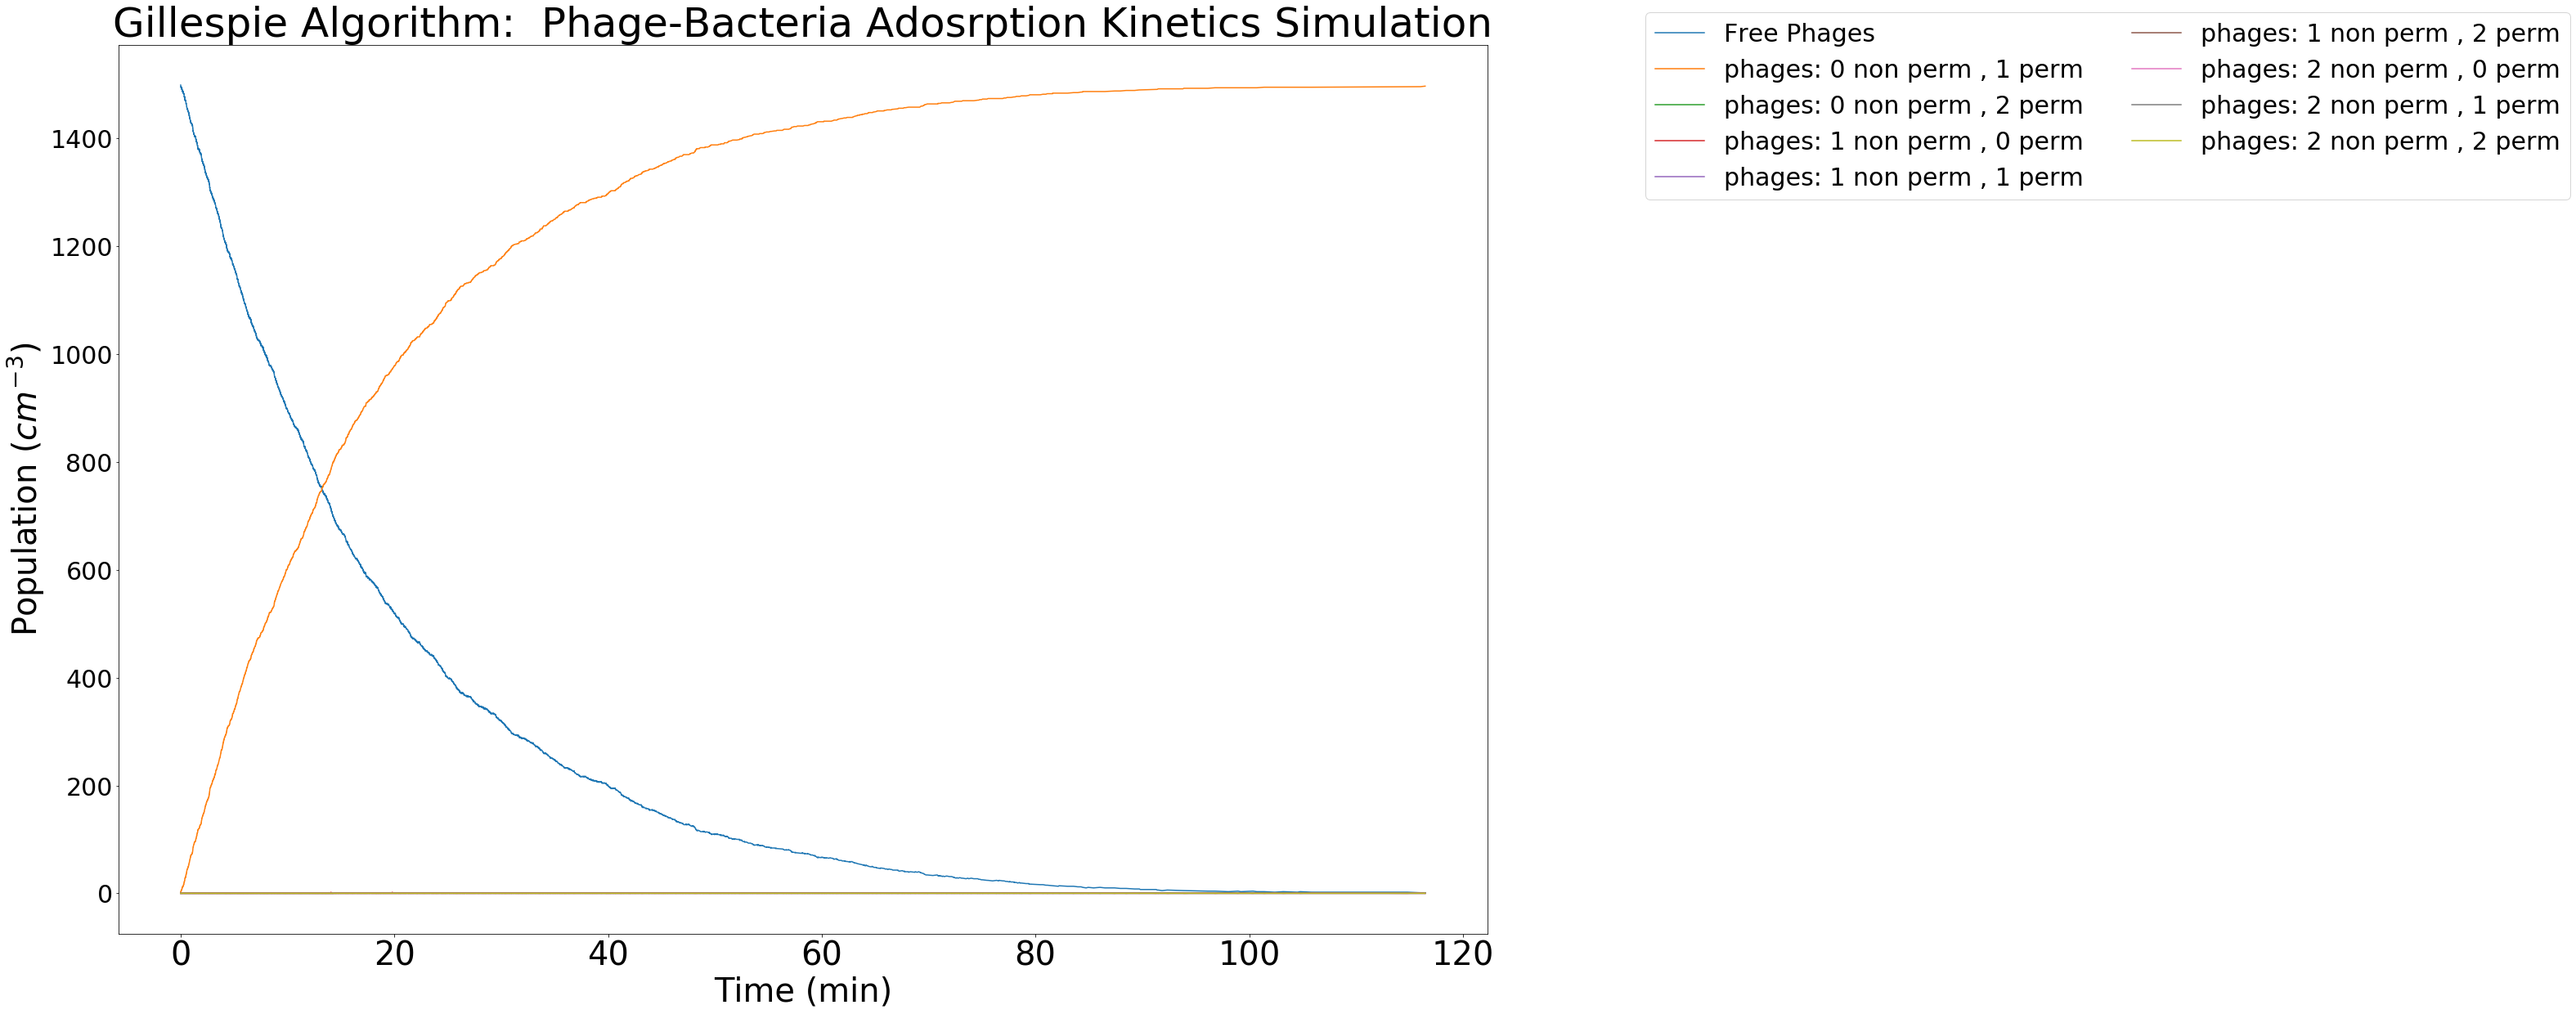

In [122]:
plt.figure(figsize=[30,20])
plt.xlabel('Time (min)',fontsize=40)
plt.ylabel('Population ($cm^{-3}$)',fontsize=40)
#plt.yscale('log')
plt.title('Gillespie Algorithm:  Phage-Bacteria Adosrption Kinetics Simulation',fontsize=50)
plt.plot(time[1:6116]/60,free_phages[1:6116],label = 'Free Phages')
for i in range(0,3):  #  nonperm
    for j in range(0,3):# perm
        if i == 0 and j == 0:
            pass;
        else:
            plt.plot(time[1:6116]/60,data_all[1:6116,i,j],label = 'phages: {} non perm , {} perm'.format(i,j))
plt.xticks(fontsize=40)
plt.yticks(fontsize=30)
plt.legend(bbox_to_anchor=(1.8, 1.05),fontsize=30,ncol=2)

Comparison to ODE model
\begin{equation}
\\ \frac{dN_{BP}}{dt} = kN_BN_P-(k'+k'')N_{BP}
\\ \frac{dN_P}{dt} = k'N_{BP} - kN_BN_P
\\ \frac{dN_B}{dt} = k'N_{BP}-kN_BN_P
\\ \frac{dN^{*}_{BP}}{dt}=k''N_{BP}
\end{equation}
$N_B$ susceptible bacteria, $N_P$ free phage, $N_{BP}$ transient bacterium-phage complexes, $N_{BP}*$ is infected cells

In [27]:
from scipy.integrate import odeint

In [120]:
def phage_kinetics(pop,t,k1,k2,k3):
    
    B = pop[0]
    P = pop[1]
    BP = pop[2]
    BP_ = pop[3]
    #print(B,P,BP,BP_)

    dBPdt = k1*B*P-(k2+k3)*BP
    dPdt = k2*BP-k1*B*P
    dBdt = k2*BP-k1*B*P
    dBP_dt = k3*BP
    #print(dBdt,dPdt,dBPdt,dBP_dt)
    return [dBdt, dPdt, dBPdt, dBP_dt];

#time points
n = 6116
t = np.linspace(0,120,n) #120 minutes divided by 6116 intervals

B = np.zeros(n)
P = np.zeros(n)
BP = np.zeros(n)
BP_ = np.zeros(n)
#initial conditions:
num_bacteria = int(3e+6)
num_phages = num_bacteria*5e-4
pop0 = [num_bacteria,num_phages,0,0]

for i in range(1,n):
    tspan = [t[i-1],t[i]]
    pop = odeint(phage_kinetics,pop0,t,args=(k1,k2,k3))
    pop0 = pop[i]
    B[i] = pop0[0]
    P[i] = pop0[1]
    BP[i] = pop0[2]
    BP_[i] = pop0[3]




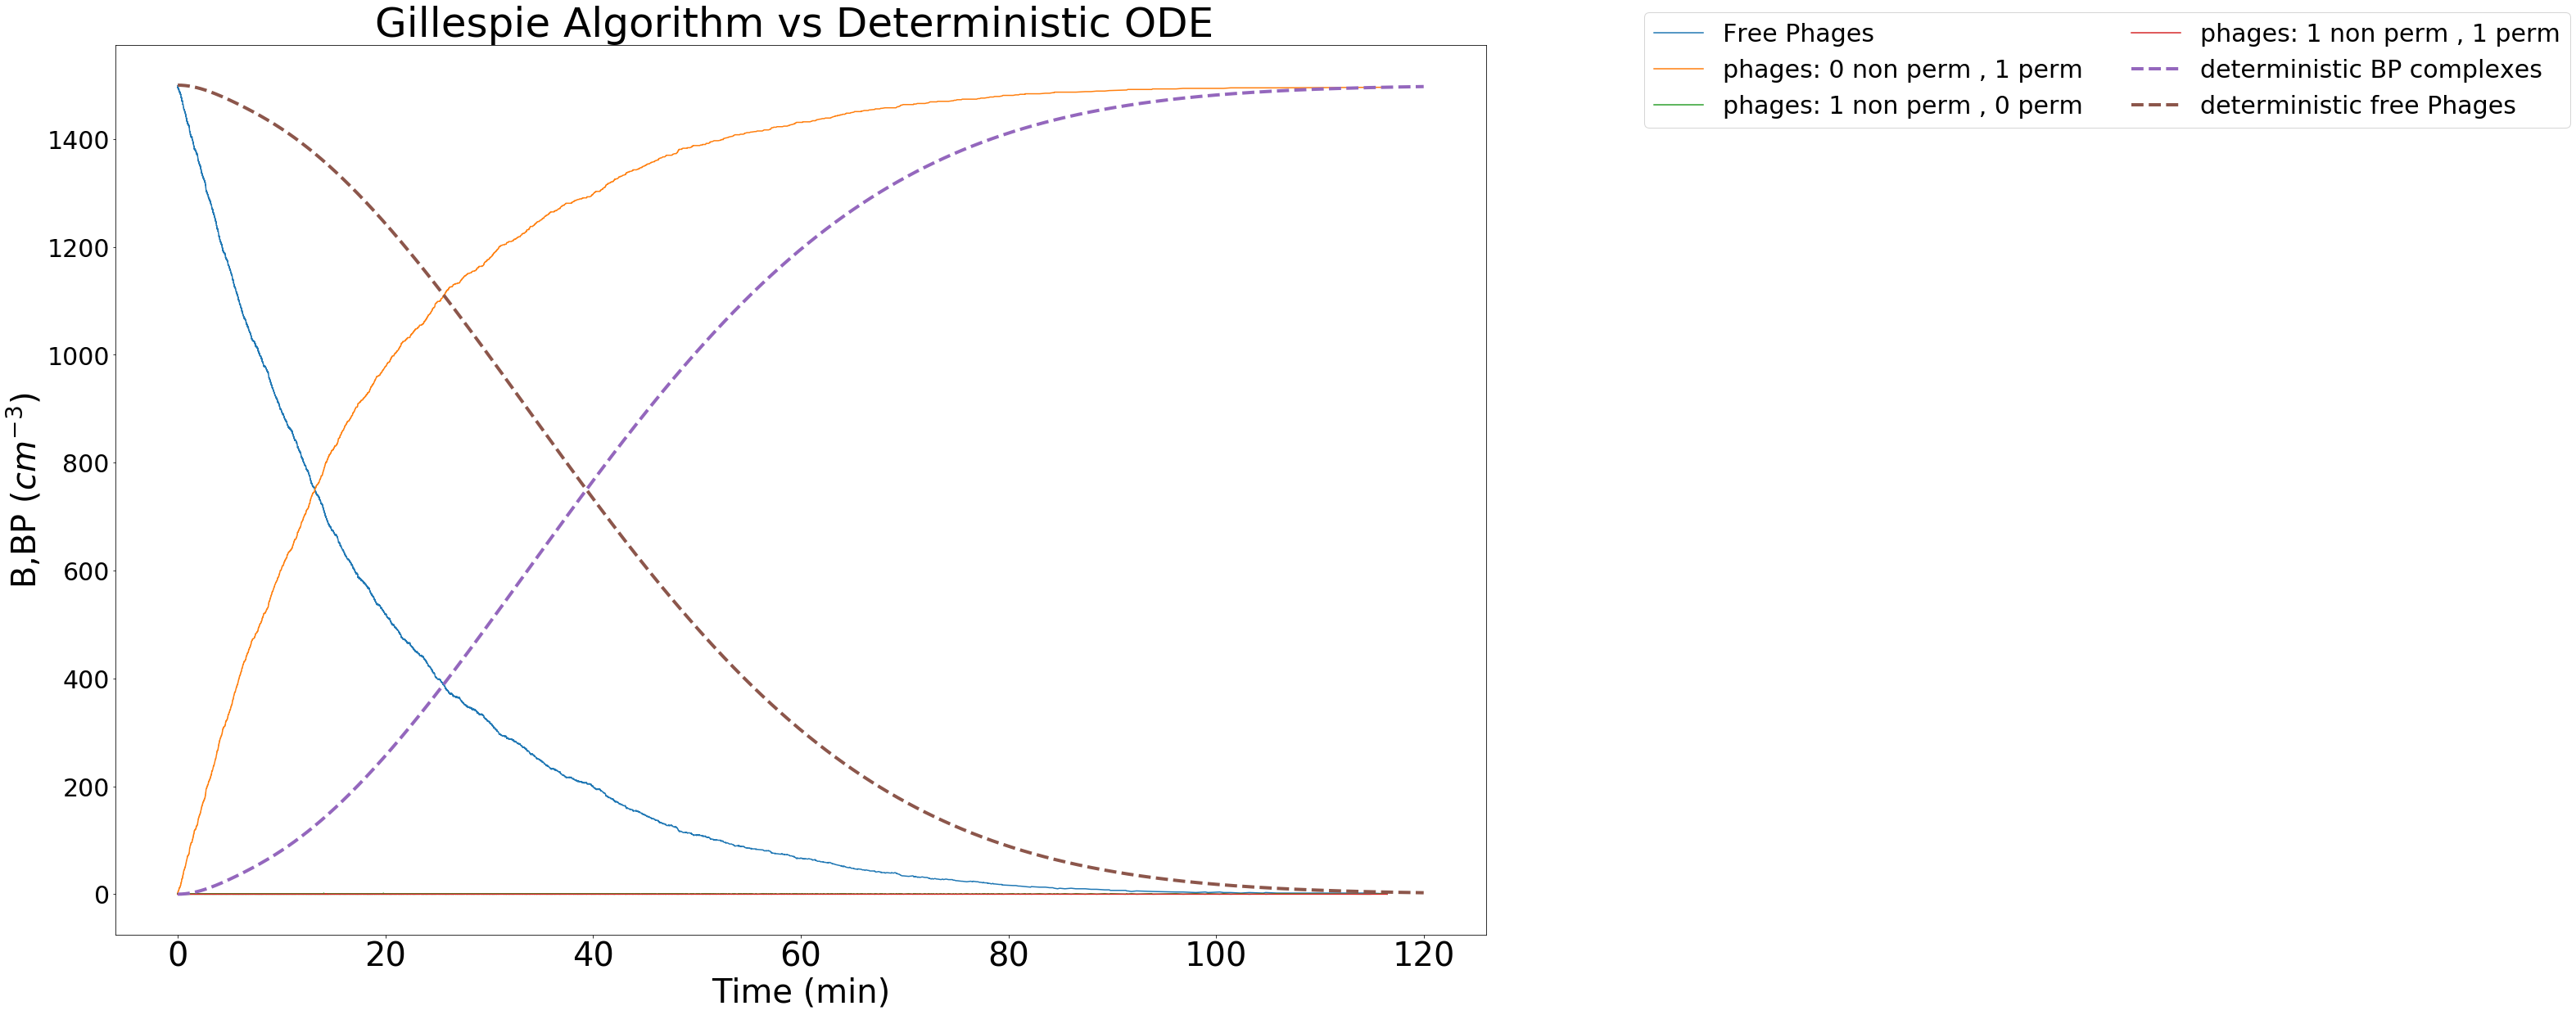

In [123]:
plt.figure(figsize=[30,20])
plt.xlabel('Time (min)',fontsize=40)
plt.ylabel('B,BP ($cm^{-3}$)',fontsize=40)
#plt.yscale('log')
plt.title('Gillespie Algorithm vs Deterministic ODE ',fontsize=50)
plt.plot(time[1:6116]/60,free_phages[1:6116],label = 'Free Phages')
for i in range(0,2):  #  nonperm
    for j in range(0,2):# perm
        if i == 0 and j == 0:
            pass;
        else:
            plt.plot(time[1:6116]/60,data_all[1:6116,i,j],label = 'phages: {} non perm , {} perm'.format(i,j))

plt.plot(t[1:6115],BP[1:6115]+BP_[1:6115],label = 'deterministic BP complexes',linestyle = '--',linewidth=4.0)
plt.plot(t[1:6115],P[1:6115], label = 'deterministic free Phages',linestyle = '--',linewidth = 4.0)
plt.xticks(fontsize=40)
plt.yticks(fontsize=30)
plt.legend(bbox_to_anchor=(1.8, 1.05),fontsize=30,ncol=2)